In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as spatial
from Helpers import helpers, twod_laplace

In [4]:
plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")

In [5]:
plain_df = plain_df.drop(columns=['class'])
plain_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks
0,120.0,0.0,0.0,0.0,0.0,64.0,62.0,126.0,2.0
1,132.0,4.0,0.0,4.0,2.0,130.0,68.0,198.0,6.0
2,133.0,2.0,0.0,5.0,2.0,130.0,68.0,198.0,5.0
3,134.0,2.0,0.0,6.0,2.0,117.0,53.0,170.0,11.0
4,132.0,4.0,0.0,5.0,0.0,117.0,53.0,170.0,9.0


In [6]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
perturbed_df_2d = perturbed_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [7]:
import random
from sklearn.preprocessing import MinMaxScaler

def get_Z_outside_domain_X(plain_df, perturbed_df):
    """tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask"""
    outside_domain_mask = np.logical_or.reduce([np.logical_or(perturbed_df[:, dim] <= plain_df[:, dim].min(), perturbed_df[:, dim] >= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])
    return outside_domain_mask

def get_radius_and_perturbation(plain_df, epsilon):
    data = {'r': [], 'x': [], 'y': []}
    # loop through each record
    for row in plain_df.values:
        p = random.random()
        theta = np.random.rand()*np.pi*2
        r = twod_laplace.inverseCumulativeGamma(epsilon, p) # draw radius distance
        private_point = twod_laplace.addVectorToPoint(row, r, theta)
        data['r'].append(r)
        data['x'].append(private_point[0])
        data['y'].append(private_point[1])

    return pd.DataFrame(data)

def transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

def inverse_transform(dataframe: pd.DataFrame, scaler: MinMaxScaler):
    return pd.DataFrame(scaler.inverse_transform(dataframe), columns=dataframe.columns)



In [8]:
tree = spatial.KDTree(plain_df_2d)
query_data = tree.query_ball_point([132.0,4.0], r=0.3)
plain_df_2d.iloc[query_data]

,baseline value,histogram_min


In [9]:
min_max_scaler = MinMaxScaler(feature_range=[-1,1])
min_max_scaler_perturbed = MinMaxScaler(feature_range=[-1,1])


In [10]:
perturbed_data_with_r = get_radius_and_perturbation(plain_df_2d, 0.5)
perturbed_data_with_r.head()

,r,x,y
0,2.731572,122.389707,60.676827
1,2.237308,133.605602,66.441927
2,4.592308,136.373651,71.115730
3,2.670524,131.467751,53.848183
4,13.203790,127.528329,40.576465


In [11]:
outside_domain_mask = get_Z_outside_domain_X(plain_df_2d.values, perturbed_data_with_r.drop(columns=['r']).values)


In [12]:
perturbed_data_with_r_outside_domain = perturbed_data_with_r.drop(columns=['r'])[outside_domain_mask]
perturbed_data_with_r_outside_domain = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain], axis=1)

In [13]:
perturbed_data_with_r_outside_domain.head()

,r,x,y
4,13.203790,127.528329,40.576465
5,2.488496,131.996675,48.523755
16,7.810332,124.974867,47.020926
28,5.970192,130.376029,44.254923
29,1.444056,131.854096,48.563334


In [14]:
# perturbed_data_with_r_outside_domain_scaled = pd.DataFrame(min_max_scaler.fit_transform(perturbed_data_with_r_outside_domain), columns=perturbed_data_with_r_outside_domain.columns)


In [15]:
random_point = perturbed_data_with_r_outside_domain.iloc[2]
plain_tree = spatial.KDTree(plain_df_2d)
perturbed_query_data = plain_tree.query_ball_point([random_point['x'], random_point['y']], r=random_point['r'])

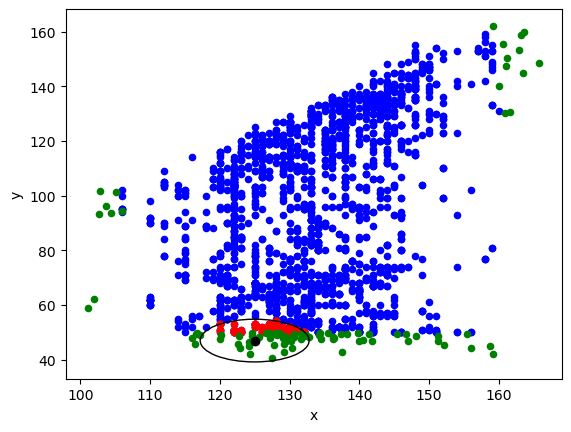

In [16]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
plain_df_2d.iloc[perturbed_query_data].plot(kind='scatter', x='baseline value', y='histogram_min', color='red', ax=ax)
perturbed_data_with_r_outside_domain.plot(kind='scatter', x='x', y='y', color='green', ax=ax)
ax.add_patch(plt.Circle((random_point['x'], random_point['y']), random_point['r'], color='black', fill=False))
ax.scatter(random_point['x'], random_point['y'], color='black')

In [17]:
perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10, columns=['x', 'y'], include_indicator=True)
# perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['baseline value', 'histogram_min'])
perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped = perturbed_data_with_r_remapped[perturbed_data_with_r_remapped['is_remapped']]
print(perturbed_data_with_r_remapped.shape, perturbed_data_with_r_outside_domain_remapped.shape)

(2126, 4) (219, 4)


In [18]:
"""perturbed_data_with_r_outside_domain_remapped = pd.concat([perturbed_data_with_r['r'][outside_domain_mask], perturbed_data_with_r_outside_domain_remapped], axis=1)
perturbed_data_with_r_outside_domain_remapped.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=True)
perturbed_data_with_r_outside_domain_remapped.head()"""
perturbed_data_with_r_remapped.head()


,r,x,y,is_remapped
0,2.731572,122.389707,60.676827,False
1,2.237308,133.605602,66.441927,False
2,4.592308,136.373651,71.115730,False
3,2.670524,131.467751,53.848183,False
4,13.203790,130.000000,50.000000,True


<AxesSubplot:xlabel='x', ylabel='y'>

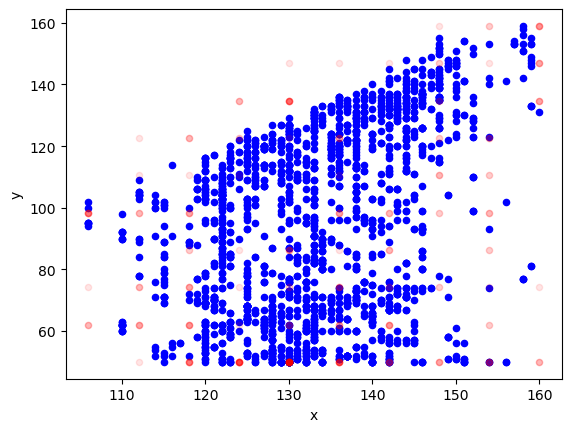

In [19]:
fig, ax = plt.subplots()
plain_df_2d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', ax=ax)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)


In [20]:
import math
import scipy.spatial as spatial


def calculate_distance(point1, point2):
    #return spatial.distance.euclidean(point1, point2)  # Euclidean distance as an example
    return np.linalg.norm(point1 - point2)

def remap_point(x, z_popularity, fake_data, real_data, radius, epsilon, plain_tree, w_x):
    w_x = len(w_x) + len(z_popularity)
    #w_q_sum = sum([len(calculate_popularity(q, real_data, radius)) for q in Q_r(x, z, real_data, radius)])
    q = Q_r(x, real_data, radius, plain_tree)
    w_q_sum = len(q)

    # q_calc = (w_q_sum * math.exp(-epsilon * calculate_distance(q, z)))
    #print(w_q_sum)
    distance_xz = calculate_distance(x, fake_data)
    #epsilon_offset = 1e-6  # Small offset to avoid division by zero or infinite results
    
    remapped_value = (w_x * math.exp(-epsilon * distance_xz)) / w_q_sum if w_q_sum > 0 else 0
    
    return remapped_value

def Q_r(x, points, radius, kd_tree=None):
    kdtree = spatial.KDTree(points) if kd_tree is None else kd_tree
    indices = kdtree.query_ball_point((x), radius)
    return [points[i] for i in indices]

def find_new_r_for_perturbed_datas_outside_domain(perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_with_Q = perturbed_data.copy()
    for index, point in perturbed_data_with_Q.iterrows():
        x = plain_df.iloc[index]
        new_r = { 'x_new': [], 'y_new': []}
        for column in ['x', 'y']:
            #print(point[column], x[column])
            polularity_x = Q_r([x[column]], [point[column]], plain_df[column].values, point['r'], plain_tree)
            #new_r[f"{column}_new"].append(remap_point([plain_df.loc[index,column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            for x_q in polularity_x:
                print(x_q)
                new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))

            coefficients = [x_new * x[column] for x_new in new_r[f"{column}_new"]] 
            sum_coefficients = sum(coefficients)
            
            probabilities = [coeff / sum_coefficients for coeff in coefficients]
            if(sum_coefficients > 0): 
                averaged = np.average(polularity_x, axis=0, weights=probabilities)
                averaged = averaged if averaged is not np.nan else point[column]
                perturbed_data_with_Q.loc[index, f"{column}_new"] = averaged
            else:
                perturbed_data_with_Q.loc[index, f"{column}_new"] = point[column]
        
    return perturbed_data_with_Q; 

In [21]:
plain_df_2d.head()
plain_df_2d_renamed = plain_df_2d.rename(columns={'baseline value': 'x', 'histogram_min': 'y'}, inplace=False)
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


In [22]:
# counts = find_new_r_for_perturbed_datas_outside_domain(perturbed_data_with_r_outside_domain_remapped.drop(columns=['is_remapped']), plain_df_2d_renamed, epsilon=0.5)

#counts = counts.where(counts['Q_r'] > 0).dropna()

In [23]:
#counts.head()

In [24]:
#print(counts['y_new'].max(), plain_df_2d_renamed['y'].max(), counts['y_new'].min(), plain_df_2d_renamed['y'].min(), perturbed_data_with_r_outside_domain_remapped['y'].max(), perturbed_data_with_r_outside_domain_remapped['y'].min())
#print(counts['x_new'].max(), plain_df_2d_renamed['x'].max(), counts['x_new'].min(), plain_df_2d_renamed['x'].min(), perturbed_data_with_r_outside_domain_remapped['x'].max(), perturbed_data_with_r_outside_domain_remapped['x'].min())

In [25]:
plain_df_2d_renamed.head()

,x,y
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


$$  \sigma(x) = \frac{w(x)e^{-\epsilon d(x, z)}}{w(q)e^{-\epsilon d(q, z)}}$$

In [26]:
"""fig, ax = plt.subplots()
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)

counts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)
counts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])"""

"fig, ax = plt.subplots()\nplain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)\n\ncounts.plot(kind='scatter', x='x_new', y='y_new', color='green', ax=ax)\ncounts.plot(kind='scatter', x='x', y='y', color='red', ax=ax)\nax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])"

In [27]:
def get_Z_outside_domain_X(plain_df, perturbed_df):
    # tree = spatial.KDTree(plain_df)
    # Query the KDTree with dataset1 to find the closest points in dataset2
    # _, closest_indices = tree.query(perturbed_df)
    # Check if each point in dataset1 is within the domain of dataset2
    in_domain = np.logical_and.reduce([np.logical_and(perturbed_df[:, dim] >= plain_df[:, dim].min(), perturbed_df[:, dim] <= plain_df[:, dim].max()) for dim in range(perturbed_df.shape[1])])

    # Create a mask for points outside the domain of dataset2
    outside_domain_mask = np.logical_not(in_domain)
    return outside_domain_mask

"""
    Optimal remapping algoritm.
    Important: Should have a "r" (radius/ radial distance) which is used to remap the data.
    @param perturbed_data: The perturbed data to be remapped. It should be grid-mapped already.
    @param plain_df: The plain data to be used for remapping. (Used to determine crowdness)
"""
def optimal_remapping (perturbed_data: pd.DataFrame, plain_df: pd.DataFrame, epsilon=0.1):
    tree = spatial.KDTree(plain_df)
    perturbed_data_copy = perturbed_data.copy()
    if perturbed_data.columns.isin(['is_remapped']).any():
        perturbed_data_copy = perturbed_data_copy[perturbed_data_copy['is_remapped']]
        perturbed_data_copy = perturbed_data_copy.drop(columns=['is_remapped'])
    if not perturbed_data_copy.columns.isin(['r']).any():
        raise ValueError("Perturbed data should have a column named 'r' which is the radius of the grid.")
    if not perturbed_data_copy.shape[1] -1 is plain_df.shape[1]:
        raise ValueError("Perturbed data should have the same number of columns as plain data.")
    if not perturbed_data_copy.columns.drop(labels=['r']).isin(plain_df.columns).all():
        raise ValueError("Perturbed data should have the same columns as plain data.")

    
    ##truncated_perturbed_data = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_copy, epsilon)
    for index, private_data_point in perturbed_data_copy.iterrows(): # loop through each point outside the domain
        non_private_data_point = plain_df.iloc[index] # get the corresponding plain data point
        list_sigma = []
        #print(non_private_data_point, private_data_point)
        # calculate w_x
        polularity_x = Q_r(non_private_data_point.values, plain_df.values, private_data_point['r'], tree)
        popularity_z = Q_r(private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], tree)
        # for every point in a radius r around the non-private data point, calculate the new r.
        for x_q in polularity_x:
            #print(x_q)
            # new_r[f"{column}_new"].append(remap_point([plain_df.loc[x_q, column]], [point[column]], plain_df[column].values, point['r'], epsilon, tree, w_x=polularity_x))
            list_sigma.append(remap_point(x_q, popularity_z, private_data_point[plain_df.columns].values, plain_df.values, private_data_point['r'], epsilon, tree, w_x=polularity_x))

        coefficients = [x_new * non_private_data_point for x_new in list_sigma] 
        #print(coefficients)
        sum_coefficients = sum(coefficients)
        
        probabilities = np.array([coeff / sum_coefficients for coeff in coefficients]) # calculate the probabilities using the coefficients
        if(sum_coefficients[sum_coefficients > 0].all()):
            perturbed_data_copy.loc[index, plain_df.columns] = np.average(polularity_x, axis=0, weights=probabilities) # calculate the new value for the point based on the average with weightes probabilities.
        #print(np.array(probabilities))

    return perturbed_data_copy

In [28]:
#perturbed_data_with_r_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_data_with_r.drop(columns=['r']).values, plain_df_2d.values, grid_size=10)
#perturbed_data_with_r_remapped = pd.DataFrame(perturbed_data_with_r_remapped, columns=['x', 'y'])
#perturbed_data_with_r_remapped = pd.concat([perturbed_data_with_r['r'], perturbed_data_with_r_remapped], axis=1)
perturbed_data_with_r_remapped.head()

,r,x,y,is_remapped
0,2.731572,122.389707,60.676827,False
1,2.237308,133.605602,66.441927,False
2,4.592308,136.373651,71.115730,False
3,2.670524,131.467751,53.848183,False
4,13.203790,130.000000,50.000000,True


In [29]:
optimal_remapped_data = optimal_remapping(perturbed_data_with_r_remapped, plain_df_2d_renamed, epsilon=0.5)

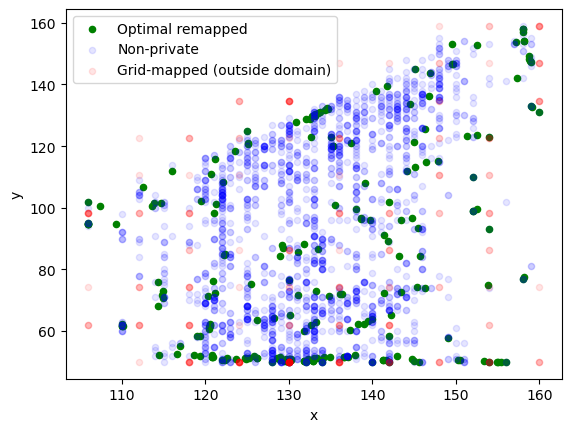

In [30]:
fig, ax = plt.subplots()
optimal_remapped_data.plot(kind='scatter', x='x', y='y', color='green', ax=ax, alpha=1)
plain_df_2d_renamed.plot(kind='scatter', x='x', y='y', color='blue', ax=ax, alpha=0.1)
perturbed_data_with_r_outside_domain_remapped.plot(kind='scatter', x='x', y='y', color='red', ax=ax, alpha=0.1)
ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])

In [31]:
plain_df_2d_renamed.min()

x    106.0
y     50.0
dtype: float64

In [32]:
def mechanism_design(plain_df, perturbed_df, grid_size=10, columns=['x', 'y'], epsilon=0.1):
    perturbed_df_with_grid_remapping = helpers.truncate_n_dimensional_laplace_noise(perturbed_df.drop(columns=['r']).values, plain_df.values, grid_size=grid_size, columns=columns, include_indicator=True)
    #perturbed_df_find_grid_remappings = perturbed_df_with_grid_remapping[perturbed_df_with_grid_remapping['is_remapped']]
    perturbed_df_find_grid_remappings_with_r = pd.concat([perturbed_df['r'], perturbed_df_with_grid_remapping], axis=1)
    perturbed_df_optimal_remapping = optimal_remapping(perturbed_df_find_grid_remappings_with_r, plain_df, epsilon=epsilon)
    return perturbed_df_optimal_remapping

In [33]:
perturbed_df_optimal_remapping = mechanism_design(plain_df_2d_renamed, perturbed_data_with_r)

<AxesSubplot:xlabel='x', ylabel='y'>

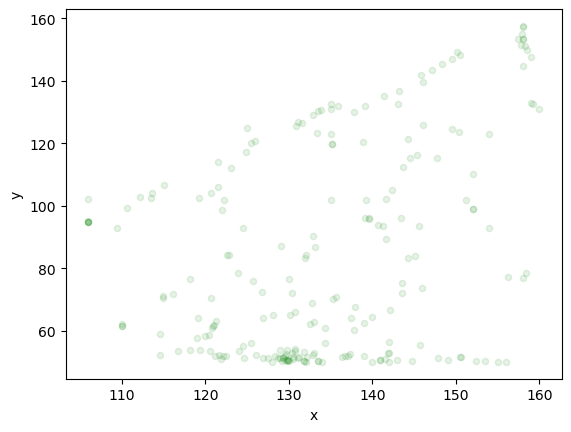

In [34]:
perturbed_df_optimal_remapping.plot(kind='scatter', x='x', y='y', color='green', alpha=0.1)

## 3D Variant

In [35]:
plain_df_3d = plain_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d = perturbed_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]
perturbed_df_3d.head()

,baseline value,histogram_min,accelerations
0,143.085375,62.000007,-1.574761
1,156.148066,67.998066,6.570822
2,151.820138,68.002038,-0.495178
3,161.102637,52.999833,6.539972
4,148.282493,53.002594,9.905883


In [36]:
from Helpers import threed_laplace

epsilon = 0.5

In [37]:
def generate_3D_noise_for_dataset(plain_df:pd.DataFrame, epsilon):
    Z = []
    R = []
    X = np.array(plain_df)
    for x in X: 
        noise = generate_3D_noise(epsilon)
        z = x + noise[:3]
        Z.append(z)
        R.append(noise[3])
    return pd.concat((pd.DataFrame(Z, columns=plain_df.columns), pd.DataFrame(R, columns=['r'])), axis=1)
def generate_3D_noise(epsilon): 
    polar_angle, azimuth, _ = threed_laplace.generate_unit_sphere() # theta, psi
    r = threed_laplace.generate_r(epsilon)
    # theta = 2 * np.pi * u[0]
    #theta = np.random.rand() * np.pi
    #phi = np.arccos(2 * u[1] - 1)
    #phi = np.random.rand() * np.pi*2 # 
    # https://mathworld.wolfram.com/SphericalCoordinates.html formula 4/5/6
    x = r * np.sin(polar_angle) * np.sin(azimuth)
    y = r * np.sin(polar_angle) * np.cos(azimuth)
    z = r * np.cos(polar_angle)
    return x, y, z, r

In [38]:
perturbed_df_3d = generate_3D_noise_for_dataset(plain_df_3d, epsilon)
#perturbed_df_3d = pd.DataFrame(perturbed_df_3d, columns=['baseline value', 'histogram_min', 'accelerations'])
perturbed_df_3d.head()

,baseline value,histogram_min,accelerations,r
0,114.184130,63.569700,0.598713,6.053657
1,130.821421,70.134009,5.114247,2.680408
2,138.427564,70.742524,-0.077755,6.426270
3,130.654510,53.052581,5.322189,4.715083
4,130.416109,50.864311,2.723191,2.949596


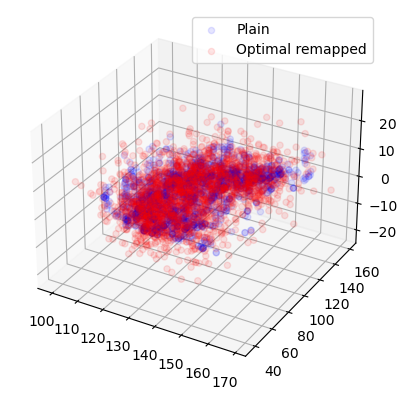

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)
ax.scatter3D(perturbed_df_3d['baseline value'], perturbed_df_3d['histogram_min'], perturbed_df_3d['accelerations'], color='red', alpha=0.1)
#plain_df_3d.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)
ax.legend(['Plain', 'Optimal remapped', 'Grid-mapped (outside domain)'])

In [40]:
perturbed_df_3d_grid_remapped = helpers.truncate_n_dimensional_laplace_noise(perturbed_df_3d.drop(columns=['r']).values, plain_df_3d.values, grid_size=10, columns=['baseline value', 'histogram_min', 'accelerations'], include_indicator=True)
perturbed_df_3d_outside_domain = perturbed_df_3d[perturbed_df_3d_grid_remapped['is_remapped']]
print(perturbed_df_3d_outside_domain.shape, perturbed_df_3d_grid_remapped.shape)

(1082, 4) (2126, 4)


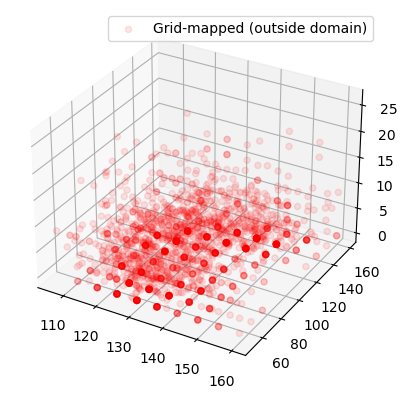

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter3D(perturbed_df_3d_outside_domain['baseline value'], perturbed_df_3d_outside_domain['histogram_min'], perturbed_df_3d_outside_domain['accelerations'], color='blue', alpha=0.1)
#ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='green', alpha=0.1)
ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
ax.legend(['Grid-mapped (outside domain)']) 
#ax.scatter3D(perturbed_df_3d_grid_remapped['baseline value'], perturbed_df_3d_grid_remapped['histogram_min'], perturbed_df_3d_grid_remapped['accelerations'], color='red', alpha=0.1)
#perturbed_df_3d_grid_remapped.plot(kind='scatter', x='baseline value', y='histogram_min', color='blue', alpha=0.1, ax=ax)

In [42]:
perturbed_df_remapped = mechanism_design(plain_df_3d, perturbed_df_3d, epsilon=0.5, columns=plain_df_3d.columns)

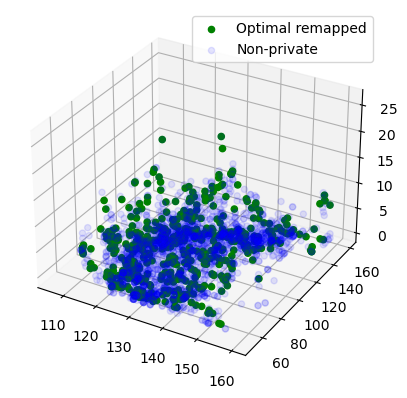

In [43]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(perturbed_df_remapped['baseline value'], perturbed_df_remapped['histogram_min'], perturbed_df_remapped['accelerations'], color='green', alpha=1)
ax.scatter3D(plain_df_3d['baseline value'], plain_df_3d['histogram_min'], plain_df_3d['accelerations'], color='blue', alpha=0.1)

ax.legend(['Optimal remapped', 'Non-private', 'Grid-mapped (outside domain)'])


## Trying mechanism design

In [44]:
from Helpers import helpers 

plain_df, perturbed_df = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/heart-dataset/heart_numerical.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/heart-dataset/")
plain_df = plain_df.drop(columns=['class'])
plain_df_3d = plain_df.loc[:, ['baseline value', 'histogram_min', 'accelerations']]

In [45]:
plain_df_3d.head()

,baseline value,histogram_min,accelerations
0,120.0,62.0,0.0
1,132.0,68.0,4.0
2,133.0,68.0,2.0
3,134.0,53.0,2.0
4,132.0,53.0,4.0


Run appropiate mechanism to generate a private dataset...
Run 3D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (795, 4)
Shapes (2126, 4) (2126, 4) (2126, 4) (2126, 5)


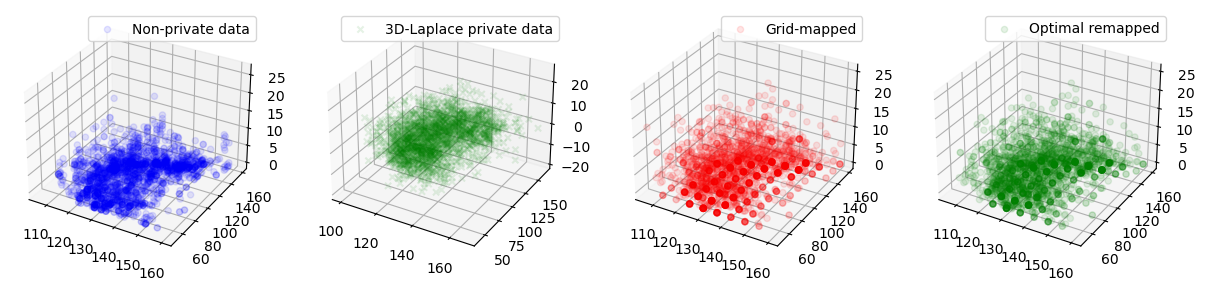

(2126, 4) (2126, 3)


In [46]:
from Helpers.ldp_mechanism import ldp_mechanism

mechanism = ldp_mechanism(epsilon=0.5)
private_dataset_3d = mechanism.randomise(non_private_dataset=plain_df_3d, epsilon=0.5, plot_validation=True)
print(private_dataset_3d.shape, plain_df_3d.shape)

In [47]:
private_dataset_3d.head()

,r,baseline value,histogram_min,accelerations
0,4.737872,118.000000,62.111111,0.000000
1,1.766218,131.857540,67.748914,2.257534
2,0.197817,133.002081,67.996218,2.197770
3,1.153088,132.958134,52.699975,2.392571
4,3.423160,132.569715,52.743995,7.365697


In [48]:
plain_df_2d = plain_df.loc[:, ['baseline value', 'histogram_min']]
plain_df_2d.head()

,baseline value,histogram_min
0,120.0,62.0
1,132.0,68.0
2,133.0,68.0
3,134.0,53.0
4,132.0,53.0


Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (81, 3)
Shapes (2126, 3) (2126, 3) (2126, 3) (2126, 4)


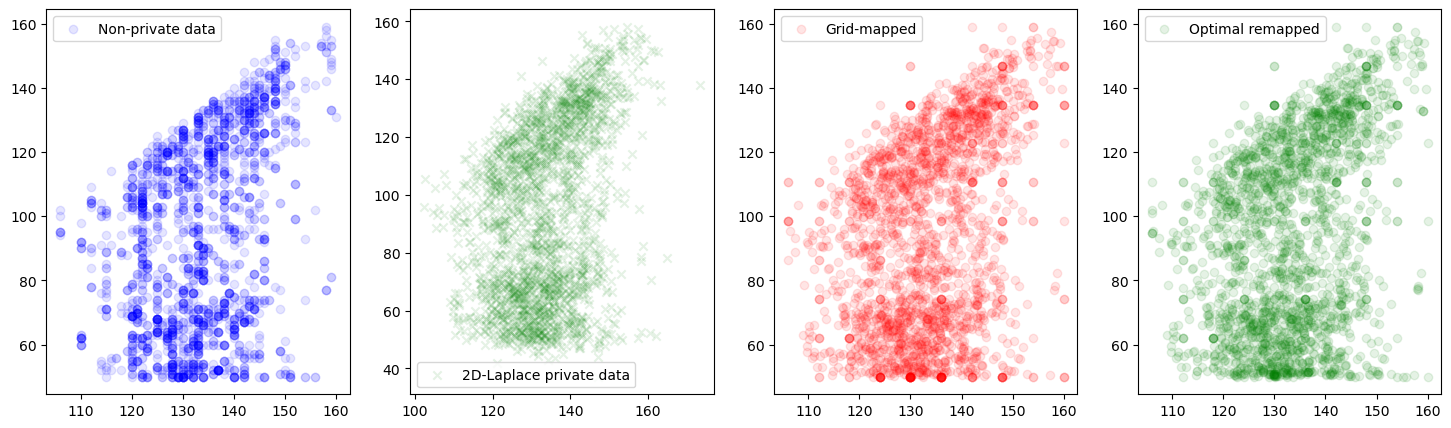

,r,baseline value,histogram_min
0,7.400480,113.987090,57.685835
1,1.852818,131.944929,66.148001
2,6.972126,135.263700,61.405593
3,1.705870,133.986129,54.705814
4,1.765626,131.828858,54.757312


In [49]:
private_dataset_2d = mechanism.randomise(plain_df_2d, plot_validation=True, epsilon=0.5)
private_dataset_2d.head()

## Trying with lower privacy budget (0.1)

Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (553, 3)
Shapes (2126, 3) (2126, 3) (2126, 3) (2126, 4)


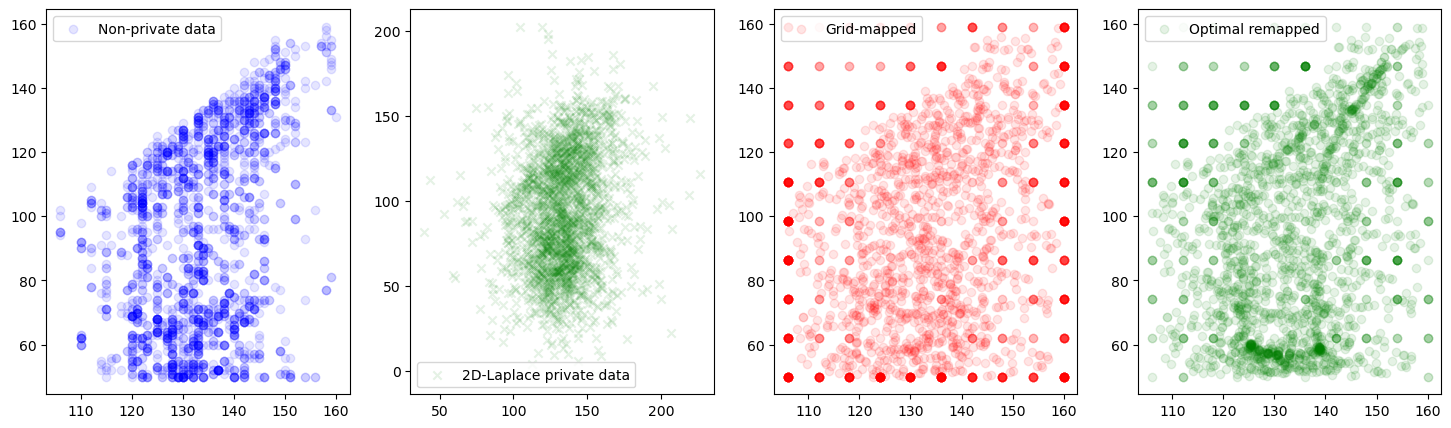

In [50]:
mechanism_more_private = ldp_mechanism(epsilon=0.1)
private_dataset_2d_more_private = mechanism_more_private.randomise(plain_df_2d, plot_validation=True, epsilon=0.1)

Run appropiate mechanism to generate a private dataset...
Run 3D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (1521, 4)
Shapes (2126, 4) (2126, 4) (2126, 4) (2126, 5)


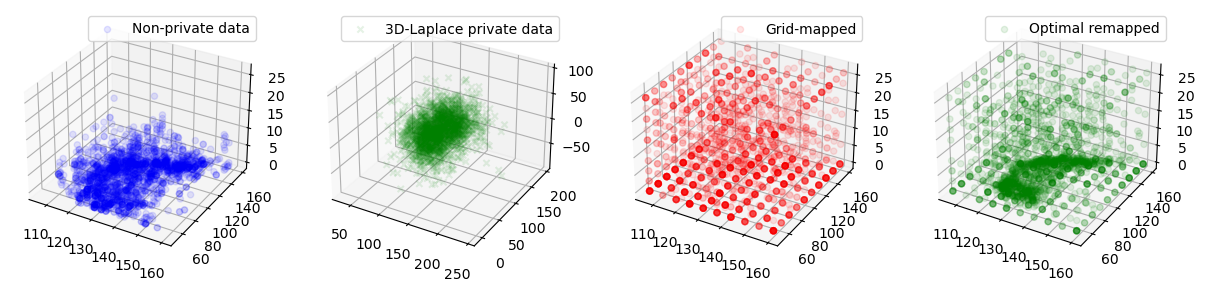

In [51]:
private_dataset_3d_more_private = mechanism_more_private.randomise(plain_df_3d, plot_validation=True, epsilon=0.1)

In [52]:
private_dataset_3d_more_private.shape

(2126, 4)

## Considering seeds dataset

In [1]:
from Helpers import helpers
plain_seed_df, _ = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/seeds-dataset/rq1.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/seeds-dataset/")
plain_seed_df_without_class = plain_seed_df.drop(columns=['class'])
plain_seed_df_without_class.head()

,area,perimeter
0,15.26,14.84
1,14.88,14.57
2,14.29,14.09
3,13.84,13.94
4,16.14,14.99


/workspaces/notebook/Helpers/ldp_mechanism.py:174: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dimensions is 2:
/workspaces/notebook/Helpers/ldp_mechanism.py:177: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dimensions is 3:
/workspaces/notebook/Helpers/ldp_mechanism.py:212: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dimensions is 2:
/workspaces/notebook/Helpers/ldp_mechanism.py:214: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dimensions is 3:


Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  is_remapped
0    15.296667  14.023333        False
1    21.180000  14.561111         True
2    10.590000  12.947778         True
3    16.473333  14.023333        False
4    14.120000  12.410000         True
..         ...        ...          ...
205  12.943333  16.712222        False
206  10.590000  12.410000         True
207  10.590000  12.410000         True
208  12.943333  16.712222        False
209  10.590000  16.712222         True

[210 rows x 3 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (120, 3)
Shapes (210, 3) (210, 3) (210, 3) (210, 4)


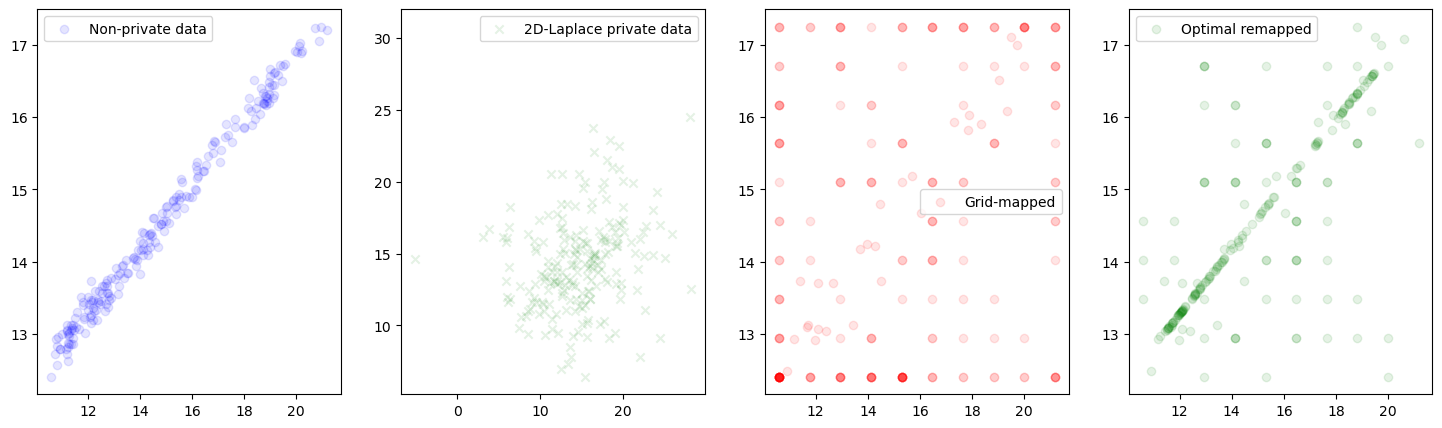

(210, 3) (210, 2)


In [2]:
from Helpers.ldp_mechanism import ldp_mechanism

mechanism = ldp_mechanism(epsilon=0.5)
private_seed_dataset = mechanism.randomise(non_private_dataset=plain_seed_df_without_class, epsilon=0.5, plot_validation=True)
print(private_seed_dataset.shape, plain_seed_df_without_class.shape)

Run appropiate mechanism to generate a private dataset...
Run 2D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  is_remapped
0    10.590000  12.410000         True
1    21.180000  17.250000         True
2    10.590000  13.485556         True
3    10.590000  12.410000         True
4    15.296667  17.250000         True
..         ...        ...          ...
205  10.590000  17.250000         True
206  10.590000  17.250000         True
207  10.590000  17.250000         True
208  17.650000  17.250000         True
209  10.590000  17.250000         True

[210 rows x 3 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.... (201, 3)
Shapes (210, 3) (210, 3) (210, 3) (210, 4)


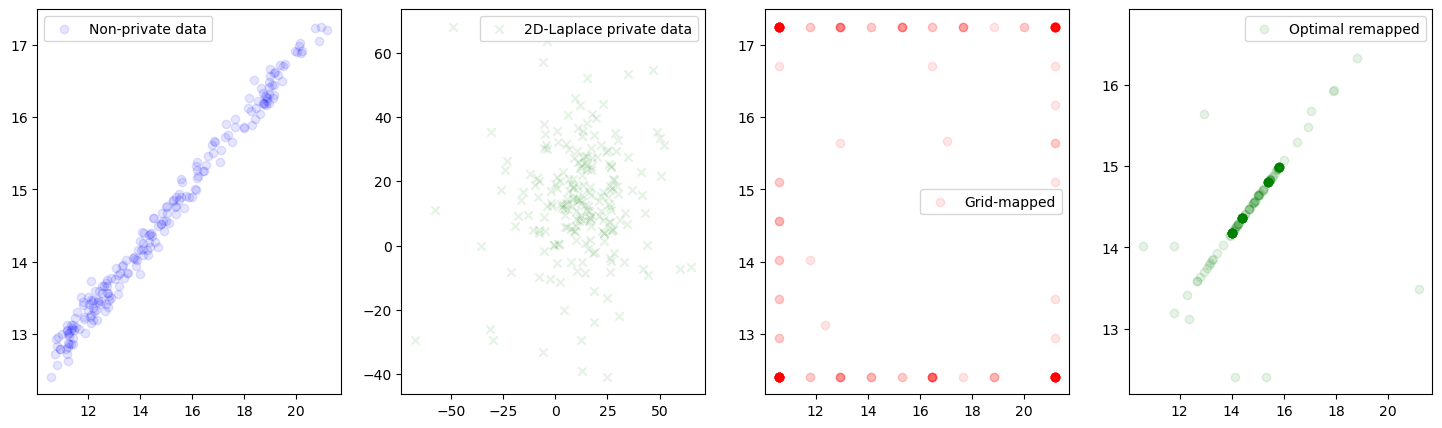

In [3]:
mechanism = ldp_mechanism(epsilon=0.1)
private_seed_dataset = mechanism.randomise(non_private_dataset=plain_seed_df_without_class, epsilon=0.1, plot_validation=True)

In [7]:
mechanism = ldp_mechanism(epsilon=0.5)
plain_seed_df_3d, _ = helpers.load_plain_and_perturbed_dataset(0.5, import_path="../data/seeds-dataset/rq2.csv", perturbed_path="../ExperimentRunners/data/nd-laplace-truncated/seeds-dataset/")
plain_seed_df_3d_without_class  = plain_seed_df_3d.drop(columns=['class'])
plain_seed_df_3d_without_class.head()

,area,perimeter,length of kernel
0,15.26,14.84,5.763
1,14.88,14.57,5.554
2,14.29,14.09,5.291
3,13.84,13.94,5.324
4,16.14,14.99,5.658


Run appropiate mechanism to generate a private dataset...
Run 3D-Laplace mechanism...
Approximate the private dataset outside the domain to be inside the domain of the non-private dataset using a grid...
          area  perimeter  length of kernel  is_remapped
0    15.296667  15.098889          5.096333        False
1    14.120000  14.561111          4.899000        False
2    14.120000  14.561111          6.675000         True
3    14.120000  14.023333          6.675000        False
4    18.826667  15.098889          6.675000         True
..         ...        ...               ...          ...
205  14.120000  14.561111          4.899000         True
206  10.590000  12.947778          6.280333        False
207  14.120000  12.947778          5.491000        False
208  11.306099  13.017772          4.923541        False
209  12.943333  13.485556          6.477667        False

[210 rows x 4 columns]
All data that was remapped using a grid, is optimally remapped...
Points outside domain.

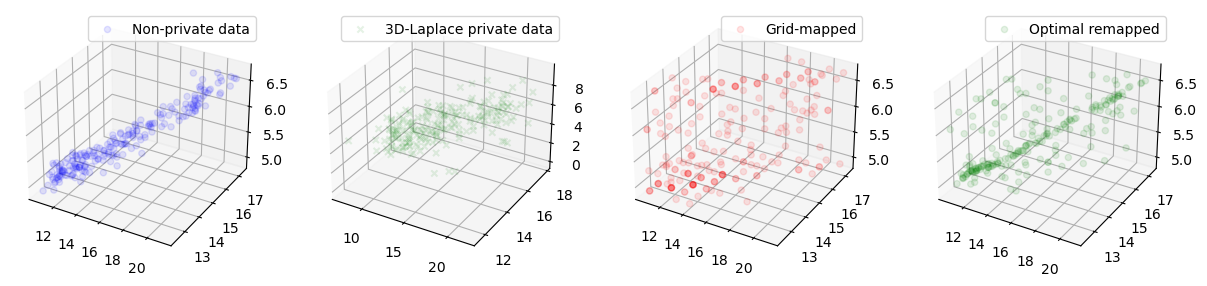

In [8]:
private_seed_dataset_3d = mechanism.randomise(non_private_dataset=plain_seed_df_3d_without_class, epsilon=0.5, plot_validation=True)

In [9]:
private_seed_dataset_3d

,r,area,perimeter,length of kernel
0,0.739909,15.296667,15.098889,5.096333
1,0.727020,14.120000,14.561111,4.899000
2,1.543670,14.369639,14.357538,5.557370
3,1.320098,14.120000,14.023333,6.675000
4,2.946189,18.133292,15.997991,6.072095
...,...,...,...,...
205,2.649817,13.858200,14.072726,5.431496
206,1.213794,10.590000,12.947778,6.280333
207,0.973678,14.120000,12.947778,5.491000
208,0.620672,11.306099,13.017772,4.923541
